In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.models import resnet18,resnet34,resnet50,resnet101,resnet152
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from torch.utils.data.sampler import WeightedRandomSampler

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [3]:
# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)
        self.classes = self.data.classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        return img, label

In [4]:
# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.2582, 0.2476, 0.2308], std=[0.3044, 0.2925, 0.2736]),
])

data_dir = '../Roadviewer/Dataset'
# Load your custom dataset
train_data = CustomDataset(data_dir + '/train', transform=transform)
# test_data = CustomDataset(data_dir + '/test', transform=transform)
val_data = CustomDataset(data_dir + '/valid', transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [137]:
mean = np.zeros(3)
std = np.zeros(3)
for data, _ in val_data:
    for i in range(3):
        mean[i] += data[i].mean()
        std[i] += data[i].std()
mean /= len(val_data)
std /= len(val_data)
print(mean)
print(std)

[0.25268943 0.24231526 0.2262851 ]
[0.29083143 0.27960314 0.26091848]


In [132]:
mean = np.zeros(3)
std = np.zeros(3)
for data, _ in train_data:
    for i in range(3):
        mean[i] += data[i].mean()
        std[i] += data[i].std()
mean /= len(train_data)
std /= len(train_data)
print(mean)
print(std)

[0.25257042 0.24238083 0.22564004]
[0.28864914 0.27758299 0.25838134]


In [5]:
# calculate number labels with 1 and 0
def count_labels(loader):
    labels = []
    for _, label in loader:
        labels.extend(label.numpy())
    return labels

train_labels = count_labels(train_loader)


In [5]:
np.unique(train_labels,return_counts=True)

(array([0, 1]), array([5397, 2622]))

In [6]:
# Set up data transformations
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.25257042,0.24238083,0.22564004], std=[0.28864914,0.27758299,0.25838134]),
])

data_dir = '../Roadviewer/Dataset'
# Load your custom dataset
train_data = CustomDataset(data_dir + '/train', transform=transform)
# test_data = CustomDataset(data_dir + '/test', transform=transform)
val_data = CustomDataset(data_dir + '/valid', transform=transform)

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [7]:
# Calculate class weights for WeightedRandomSampler
class_counts = [5397, 2622]  # Replace with actual class counts
num_samples = sum(class_counts)
class_weights = [num_samples / count for count in class_counts]
weights = [class_weights[label] for label in train_labels]
# Create WeightedRandomSampler
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), len(weights))
# Create data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, sampler = sampler)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train samples: 8019
Validation samples: 531
Classes: ['Absent', 'Present']


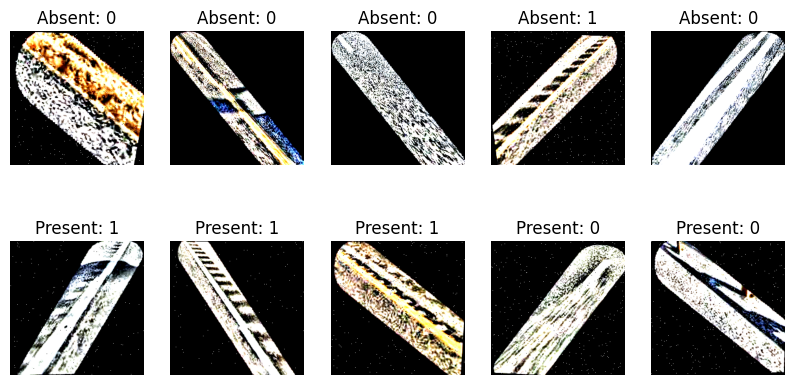

In [9]:
# print the number of samples in each set
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
# print(f"Test samples: {len(test_data)}")
# print the number of classes
print(f"Classes: {train_data.classes}")
# plot some samples in the training set, 5 absent and 5 present

plt.figure(figsize=(10, 5))
for i in range(5):
    idx = random.randint(0, len(train_data))
    img, label = train_data[idx]
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"Absent: {label}")
    plt.axis('off')
for i in range(5):
    idx = random.randint(0, len(train_data))
    img, label = train_data[idx]
    plt.subplot(2, 5, i+6)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(f"Present: {label}")
    plt.axis('off')
plt.show()



In [7]:
import torch.optim.lr_scheduler as lr_scheduler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')
# Define ResNet model
model = resnet18(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)
# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust step_size and gamma as needed
criterion = nn.CrossEntropyLoss()

Using cuda for inference


/home/czh/anaconda3/envs/lane-det/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/czh/anaconda3/envs/lane-det/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Training loop
num_epochs = 100
# save_interval = 10
best_val_accuracy = 0.0
best_epoch = 0
best_f1_socre = 0
save_path = r'../Roadviewer/TrainingRes18'
if not os.path.exists(save_path):
    os.makedirs(save_path)
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())

    val_accuracy = 100 * correct / total
    precision = precision_score(true_labels, predicted_labels, average='binary')
    recall = recall_score(true_labels, predicted_labels, average='binary')
    f1 = f1_score(true_labels, predicted_labels, average='binary')

    print(f"Epoch [{epoch+1}/{num_epochs}]: Val Loss: {val_loss:.4f}, Train Loss: {train_loss:.4f},Val Acc: {val_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Save best model checkpoint
    if f1 > best_f1_socre:
        best_f1_socre = f1
        best_epoch = epoch
        torch.save(model.state_dict(), os.path.join(save_path,'resnet_custom_model_best.pth'))


    torch.save(model.state_dict(), os.path.join(save_path,f'last_epoch.pth'))
    print(f"Saved model checkpoint at epoch {epoch+1} to {save_path}")

# Final save after all epochs
torch.save(model.state_dict(), 'resnet_custom_model_final.pth')
print(f"Best model achieved at epoch {best_epoch+1} with validation accuracy {best_val_accuracy:.2f}%")

100%|██████████| 126/126 [00:30<00:00,  4.18it/s]


Epoch [1/100]: Val Loss: 3.2147, Train Loss: 50.2946,Val Acc: 89.45%
Precision: 0.8313, Recall: 0.8313, F1-score: 0.8313
Saved model checkpoint at epoch 1 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.45it/s]


Epoch [2/100]: Val Loss: 2.9713, Train Loss: 27.5497,Val Acc: 88.89%
Precision: 0.8204, Recall: 0.8253, F1-score: 0.8228
Saved model checkpoint at epoch 2 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.31it/s]


Epoch [3/100]: Val Loss: 3.2662, Train Loss: 23.9455,Val Acc: 90.77%
Precision: 0.9333, Recall: 0.7590, F1-score: 0.8372
Saved model checkpoint at epoch 3 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.29it/s]


Epoch [4/100]: Val Loss: 5.1941, Train Loss: 18.3038,Val Acc: 88.70%
Precision: 0.9015, Recall: 0.7169, F1-score: 0.7987
Saved model checkpoint at epoch 4 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.33it/s]


Epoch [5/100]: Val Loss: 2.7274, Train Loss: 14.4262,Val Acc: 93.03%
Precision: 0.8817, Recall: 0.8976, F1-score: 0.8896
Saved model checkpoint at epoch 5 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:30<00:00,  4.19it/s]


Epoch [6/100]: Val Loss: 3.7497, Train Loss: 12.5585,Val Acc: 90.40%
Precision: 0.8528, Recall: 0.8373, F1-score: 0.8450
Saved model checkpoint at epoch 6 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.28it/s]


Epoch [7/100]: Val Loss: 6.3969, Train Loss: 10.2727,Val Acc: 87.95%
Precision: 0.9474, Recall: 0.6506, F1-score: 0.7714
Saved model checkpoint at epoch 7 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.24it/s]


Epoch [8/100]: Val Loss: 2.8085, Train Loss: 8.6764,Val Acc: 94.35%
Precision: 0.9198, Recall: 0.8976, F1-score: 0.9085
Saved model checkpoint at epoch 8 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.26it/s]


Epoch [9/100]: Val Loss: 2.8888, Train Loss: 7.2567,Val Acc: 92.84%
Precision: 0.9156, Recall: 0.8494, F1-score: 0.8812
Saved model checkpoint at epoch 9 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:30<00:00,  4.11it/s]


Epoch [10/100]: Val Loss: 3.4748, Train Loss: 8.3891,Val Acc: 91.34%
Precision: 0.8947, Recall: 0.8193, F1-score: 0.8553
Saved model checkpoint at epoch 10 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:30<00:00,  4.19it/s]


Epoch [11/100]: Val Loss: 4.3280, Train Loss: 6.6329,Val Acc: 91.34%
Precision: 0.8750, Recall: 0.8434, F1-score: 0.8589
Saved model checkpoint at epoch 11 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.26it/s]


Epoch [12/100]: Val Loss: 3.6068, Train Loss: 3.1044,Val Acc: 93.03%
Precision: 0.8909, Recall: 0.8855, F1-score: 0.8882
Saved model checkpoint at epoch 12 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:31<00:00,  4.06it/s]


Epoch [13/100]: Val Loss: 3.5899, Train Loss: 4.7004,Val Acc: 91.34%
Precision: 0.8659, Recall: 0.8554, F1-score: 0.8606
Saved model checkpoint at epoch 13 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:29<00:00,  4.30it/s]


Epoch [14/100]: Val Loss: 4.1792, Train Loss: 4.5644,Val Acc: 91.53%
Precision: 0.8497, Recall: 0.8855, F1-score: 0.8673
Saved model checkpoint at epoch 14 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.41it/s]


Epoch [15/100]: Val Loss: 6.8236, Train Loss: 3.0575,Val Acc: 87.57%
Precision: 0.8472, Recall: 0.7349, F1-score: 0.7871
Saved model checkpoint at epoch 15 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.42it/s]


Epoch [16/100]: Val Loss: 3.7832, Train Loss: 5.1687,Val Acc: 91.90%
Precision: 0.9073, Recall: 0.8253, F1-score: 0.8644
Saved model checkpoint at epoch 16 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.38it/s]


Epoch [17/100]: Val Loss: 4.1697, Train Loss: 2.8379,Val Acc: 92.47%
Precision: 0.8841, Recall: 0.8735, F1-score: 0.8788
Saved model checkpoint at epoch 17 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.35it/s]


Epoch [18/100]: Val Loss: 3.4032, Train Loss: 3.7255,Val Acc: 92.66%
Precision: 0.8994, Recall: 0.8614, F1-score: 0.8800
Saved model checkpoint at epoch 18 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.36it/s]


Epoch [19/100]: Val Loss: 4.2653, Train Loss: 2.3722,Val Acc: 91.15%
Precision: 0.9048, Recall: 0.8012, F1-score: 0.8498
Saved model checkpoint at epoch 19 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.41it/s]


Epoch [20/100]: Val Loss: 3.4540, Train Loss: 1.4122,Val Acc: 92.09%
Precision: 0.8605, Recall: 0.8916, F1-score: 0.8757
Saved model checkpoint at epoch 20 to ../Roadviewer/TrainingRes18


100%|██████████| 126/126 [00:28<00:00,  4.40it/s]


Epoch [21/100]: Val Loss: 4.5705, Train Loss: 2.8076,Val Acc: 92.47%
Precision: 0.8938, Recall: 0.8614, F1-score: 0.8773
Saved model checkpoint at epoch 21 to ../Roadviewer/TrainingRes18


 15%|█▌        | 19/126 [00:04<00:25,  4.16it/s]


KeyboardInterrupt: 

In [8]:
# inference one image

from PIL import Image
def inference(model,img_path):
    model.eval()
    img = Image.open(img_path)
    img = transform(img).unsqueeze(0)
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    return predicted.item()

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

save_path = r'../Roadviewer/TrainingRes18'
# read model from checkpoint
ckpt_path = os.path.join(save_path,'resnet_custom_model_best.pth')
model = resnet18(pretrained=True)
num_classes = len(train_data.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(ckpt_path))
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
img.shape

torch.Size([1, 3, 256, 256])

In [33]:
img.shape

torch.Size([1, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

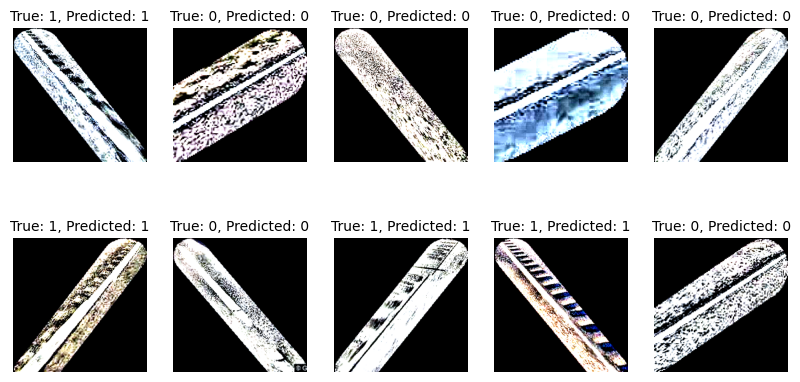

In [32]:
# randomly select 10 images from the validation set and plot them with their predicted labels in 5 x 2 subplots
plt.figure(figsize=(10, 5))
for i in range(10):
    idx = random.randint(0, len(val_data))
    img, label = val_data[idx]
    img = img.unsqueeze(0)
    img = img.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    plt.subplot(2, 5, i+1)
    plt.imshow(np.transpose(img.squeeze().cpu(), (1, 2, 0)))
    plt.title(f"True: {label}, Predicted: {predicted.item()}", fontsize = 10)
    plt.axis('off')
# plt.savefig('../Roadviewer/TestRes/inference_18.png',dpi = 600)
plt.show()